## Imports and functions

In [1]:
import datetime
from pathlib import Path
from typing import Dict, List, Union
import warnings
warnings.filterwarnings("ignore")

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams.update({'figure.max_open_warning': 0})
PARAMS = {'legend.fontsize': 'xx-large',
          'legend.title_fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(PARAMS)

TIME_FORMAT = '%Y-%m-%d'
INT_TYPE = 'int32'

In [2]:
def load_data(locus_weights_path: Union[str, Path],
              temperature_path: Union[str, Path],
              locus_group_matching_path: Union[str, Path],
              fresh_water_dates_path: Union[str, Path],
              sw_fw_matching_path: Union[str, Path],
              sw_fw_matching_path_with_cnt: Union[str, Path],
              final_locus_weighted_path: Union[str, Path],
              mortality_path: Union[str, Path]) -> Dict[str, pd.DataFrame]:
    
    locus_weights = pd.read_csv(locus_weights_path)
    locus_weights.starttime = pd.to_datetime(locus_weights.starttime, format=TIME_FORMAT)
    locus_weights.endtime = pd.to_datetime(locus_weights.endtime, format=TIME_FORMAT)
    
    temperature = pd.read_csv(temperature_path)
    temperature.event_date = pd.to_datetime(temperature.event_date, format=TIME_FORMAT)
    temperature.locus_group_id=temperature.locus_group_id.astype(INT_TYPE)
    temperature['event_year'] = temperature['event_date'].dt.year

    locus_group_matching = pd.read_csv(locus_group_matching_path)
    locus_group_matching = locus_group_matching.astype(INT_TYPE)

    fresh_water_dates = pd.read_csv(fresh_water_dates_path)
    for d in ['first_movement_date', 'first_feeding_date', 'shipout_date']:
        fresh_water_dates[d] = pd.to_datetime(fresh_water_dates[d], format=TIME_FORMAT)

    sw_fw_matching = pd.read_csv(sw_fw_matching_path)
    sw_fw_matching_with_cnt = pd.read_csv(sw_fw_matching_path_with_cnt)

    sw_fw_cols = ['target_seawater_locus_id',
                  'transport_date',
                  'ponding_date',
                  'pretransfer_fw_locus_population_id',
                  'fish_count_shipped_out',
                  'avg_weight_g_stocked']
    sw_fw_matching = sw_fw_matching[sw_fw_matching.origin_site_type == 'Freshwater'][sw_fw_cols]
    sw_fw_matching.pretransfer_fw_locus_population_id = sw_fw_matching.\
    pretransfer_fw_locus_population_id.astype(INT_TYPE)

    final_locus_weighted = pd.read_csv(final_locus_weighted_path)
    final_locus_weighted.event_date = pd.to_datetime(final_locus_weighted.event_date)

    mortality = pd.read_csv(mortality_path)
    mortality['transfer_date'] = pd.to_datetime(mortality['transfer_date'], format=TIME_FORMAT)
    mortality['transport_year']= mortality['transfer_date'].dt.year


    dataframes = {
        'temperature': temperature,
        'locus_weigts': locus_weights,
        'locus_group_matching': locus_group_matching,
        'final_locus_weighted': final_locus_weighted,
        'fresh_water_dates': fresh_water_dates,
        'sw_fw_matching': sw_fw_matching,
        'sw_fw_matching_with_cnt': sw_fw_matching_with_cnt,
        'mortality': mortality
    }
    
    return dataframes

def weighted_avg(x, weight, factor):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        tmp = x[[weight, factor]].dropna()
        weighted_sum = (tmp[weight] * tmp[factor]).sum()
        count_sum = tmp[weight].sum()
        return weighted_sum / count_sum
    
#this is to not calculate aggregates if at least one value on the main factor column is NaN
def apply_condition(group,main_factor,agg_function):
    if group[main_factor].isnull().any():
        return np.nan
    else:
        return agg_function(group[main_factor])

def create_ph_aggregated_factors(ph_df, main_factor, agg_function, function_name, env_type='ph'):
    """Creates features on final_locus_population_id_level"""
    agg_df = pd.DataFrame()
    
    agg_df[f'{env_type}-transfer_feeding-{function_name}'] = ph_df[before_transfer & after_first_feeding] \
    .groupby('final_locus_population_id').apply(lambda x: apply_condition(x, main_factor, agg_function))

    agg_df[f'{env_type}-transfer_vaccination-{function_name}'] = ph_df[before_transfer & after_vaccination]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x, main_factor, agg_function))
    
    for week in weeks_before_transfer:
        weeks_before_transfer_date = ph_df['shipout_date'] - pd.to_timedelta(week, unit='W')
        condition = ph_df['event_date'] > weeks_before_transfer_date
        agg_df[f'{env_type}-{week}_weeks_before_transfer-{function_name}'] = ph_df[before_transfer & condition]\
        .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x, main_factor, agg_function))

    mean_df = pd.concat([agg_df.mean(), agg_df.std()], axis=1).rename(columns={0: 'mean', 1: 'std'})
    
    for col in agg_df.columns[:]:
        agg_df[f'{col}-from_mean'] = agg_df[col] - mean_df.loc[col]['mean']
        agg_df[f'{col}-from_mean-abs'] = np.abs(agg_df[col] - mean_df.loc[col]['mean'])

    return agg_df

def create_ph_aggregated_factors_threshold(ph_df, main_factor, lower_bound, upper_bound, agg_function, condition_type, env_type='ph'):
    """Creates features on final_locus_population_id_level"""
    agg_df = pd.DataFrame()
    
    higher_max = f'{env_type}-{condition_type}-higher_max-{upper_bound}'
    lower_min = f'{env_type}-{condition_type}-lower_min-{lower_bound}'
    btw_min_max = f'{env_type}-{condition_type}-btw_min_max-{lower_bound}-{upper_bound}'
    
    relative_higher_max = f'{env_type}-{condition_type}-relative_higher_max-{upper_bound}'
    relative_lower_min = f'{env_type}-{condition_type}-relative_lower_min-{lower_bound}'
    relative_out_min_max = f'{env_type}-{condition_type}-relative_out_min_max-{lower_bound}-{upper_bound}'


    agg_df[higher_max] = ph_df[ph_df[main_factor] > upper_bound]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df[lower_min] = ph_df[ph_df[main_factor] < lower_bound]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df[btw_min_max] = ph_df[ph_df[main_factor].between(lower_bound, upper_bound)]\
    .groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df['measurements_count'] = ph_df.groupby(['final_locus_population_id']).apply(lambda x: apply_condition(x,main_factor,agg_function))

    agg_df[higher_max] = agg_df[higher_max].fillna(0).astype('int64')
    agg_df[lower_min] = agg_df[lower_min].fillna(0).astype('int64')
    agg_df[btw_min_max] = agg_df[btw_min_max].fillna(0).astype('int64')

    
    agg_df[relative_higher_max] = agg_df[higher_max] / agg_df['measurements_count']
    agg_df[relative_lower_min] =  agg_df[lower_min] /  agg_df['measurements_count']
    agg_df[relative_out_min_max] = 1 - (agg_df[btw_min_max] /agg_df['measurements_count'])
    agg_df.drop(columns='measurements_count', inplace=True)
        
    return agg_df

def create_factors_df(agg_ph_df, factors, key_columns, weight_column, weighted_func):
    """Creates factors df on key_columns level using weight_column to calculate weighted average"""
    factors_dfs = []
    print('Weighting factors')
    for factor in tqdm(factors):
        tmp = agg_ph_df.groupby(key_columns)\
        .apply(weighted_func, weight_column, factor).reset_index().rename(columns={0: factor})
        factors_dfs.append(tmp)

    factor_df = factors_dfs[0]
    for df in factors_dfs[1:]:
        factor_df = factor_df.merge(df, on=key_columns, how='inner')
    return factor_df

def plot_factors(factors_df, path):
    pairplot = sns.pairplot(factors_df[np.append(corr_df.index, 'mortality')], size=(20, 15))
    plt.title('Mortality vs feature pairplot')
    plt.show()

    for ax in pairplot.axes.flatten():
        # rotate x axis labels
        ax.set_xlabel(ax.get_xlabel(), rotation=45)
        # rotate y axis labels
        ax.set_ylabel(ax.get_ylabel(), rotation=0)
        # set y labels alignment
        ax.xaxis.get_label().set_horizontalalignment('right')
        ax.yaxis.get_label().set_horizontalalignment('right')
    pairplot.figure.savefig(path / 'mortality_vs_feature_pairplot.jpg')

## Data processing

In [3]:
vaccines = pd.read_csv('data/vaccines_with_final_locus_population_id.csv')
vaccines['VAC_EVENT_DATE'] = pd.to_datetime(vaccines['VAC_EVENT_DATE'] , format=TIME_FORMAT)
vaccines_agg = pd.DataFrame(vaccines.groupby('FINAL_LOCUS_POPULATION_ID')['VAC_EVENT_DATE'].mean())

tgc = pd.read_csv('data/transfers_until2023Feb28_with_sw_growth_targets.csv')

In [4]:
ph_data = pd.read_csv('data/recambio_data_locus_population_unsmoothed.csv')
# ph_data = pd.read_csv('data/ph_final_lg_grouped.csv')
# ph_data = pd.read_csv('../ph/data/ph_data_smoothed.csv')

vaccines = pd.read_csv('data/vaccines_with_final_locus_population_id.csv')
vaccines['VAC_EVENT_DATE'] = pd.to_datetime(vaccines['VAC_EVENT_DATE'] , format=TIME_FORMAT)
vaccines_agg = pd.DataFrame(vaccines.groupby('FINAL_LOCUS_POPULATION_ID')['VAC_EVENT_DATE'].mean())

In [5]:
dataframes = load_data(locus_weights_path='data/evt_movement_ratio_with_dates.csv',
                       temperature_path='data/temperature_for_CAM.csv',
                       locus_group_matching_path='data/locus_locus_group_matching.csv',
                       fresh_water_dates_path='data/FW_cycle_dates.csv',
                       sw_fw_matching_path='data/seawater_freshwater_matching.csv',
                       sw_fw_matching_path_with_cnt='data/sw_locus_fw_locus_population_with_counts.csv',
                       final_locus_weighted_path='data/lw_alldates_final_locus.csv',
                       mortality_path='data/smolt_dataset_transfers_until2023Feb28_narrow.csv')

temperature = dataframes['temperature']
locus_weights = dataframes['locus_weigts']
locus_group_matching = dataframes['locus_group_matching']
final_locus_weighted = dataframes['final_locus_weighted']
fresh_water_dates = dataframes['fresh_water_dates']
sw_fw_matching = dataframes['sw_fw_matching']
mortality = dataframes['mortality']
sw_fw_matching_with_cnt = dataframes['sw_fw_matching_with_cnt']

In [6]:
fresh_water_dates.rename(columns={'pretransfer_fw_locus_population_id': 'final_locus_population_id'}, inplace=True)

ph_data_with_dates = ph_data.merge(
    fresh_water_dates,
    how='inner'
)

ph_data_with_dates = ph_data_with_dates.merge(
    vaccines_agg,
    left_on='final_locus_population_id',
    right_on='FINAL_LOCUS_POPULATION_ID',
    how='inner'
)

In [7]:
sw_fw_matching.transport_date = pd.to_datetime(sw_fw_matching.transport_date, format=TIME_FORMAT)
ph_data_with_dates['shipout_year'] = ph_data_with_dates['shipout_date'].dt.year

sw_fw_matching_with_cnt.transfer_date = pd.to_datetime(sw_fw_matching_with_cnt['transfer_date'], format=TIME_FORMAT)
sw_fw_matching_with_cnt['transfer_year'] = sw_fw_matching_with_cnt['transfer_date'].dt.year

In [8]:
mortality_cols = ['locus_id',
                  'fish_group_id',
                  'transfer_year',
                  'transfer_month',
                  'transfer_month_year',
                  'transfer_season',
                  'transfer_season2',
                  'total_count',
                  'total_mortality_perc_90']

sw_cols = ['to_locus_id',
           'to_fish_group_id',
           'transfer_date',
           'from_locus_population_id',
           'from_count_stocking',
           'transfer_year']

mortality_final_locus = mortality[mortality_cols].merge(
    sw_fw_matching_with_cnt[sw_cols],
    left_on=['fish_group_id', 'locus_id','transfer_year'],
    right_on=['to_fish_group_id', 'to_locus_id','transfer_year'],
    how='left'
)

mortality_final_locus['from_locus_population_id'] = mortality_final_locus['from_locus_population_id'].fillna(0).astype('int32')

In [9]:
before_transfer = ph_data_with_dates['event_date'] < ph_data_with_dates['shipout_date']
after_vaccination = ph_data_with_dates['event_date'] > ph_data_with_dates['VAC_EVENT_DATE']
before_vaccination = ph_data_with_dates['event_date'] < ph_data_with_dates['VAC_EVENT_DATE']
after_first_feeding = ph_data_with_dates['event_date'] > ph_data_with_dates['first_feeding_date']
weeks_before_transfer = [2, 4, 6, 8]
#name of column with values of the factor
main_factor = 'value'
key_columns = ['locus_id','fish_group_id','transfer_year']

## Factors aggregation

In [10]:
agg_functions = {
    'mean': np.mean,
    'min': np.min,
    'max': np.max,
    'std': np.std,
    'cv': lambda x: np.std(x) / np.mean(x),  # coefficient of variation
    'threshold': np.count_nonzero,
}

In [11]:
six_weeks_condition = ph_data_with_dates['event_date'] > (ph_data_with_dates['shipout_date'] - pd.to_timedelta(6, unit='W'))
eight_weeks_condition = ph_data_with_dates['event_date'] > (ph_data_with_dates['shipout_date'] - pd.to_timedelta(8, unit='W'))
threshold_conditions = {
    '6_weeks_before_transfer': before_transfer & six_weeks_condition,
    '8_weeks_before_transfer': before_transfer & eight_weeks_condition,
    'vaccination_transfer': before_transfer & after_vaccination,
    'first_feeding_transfer': before_transfer & after_first_feeding,
    'first_feeding_vaccination': after_first_feeding & before_vaccination,
}

In [12]:
ph_data.value.describe()

count    521899.000000
mean         40.570301
std          25.774131
min           0.000000
25%          23.441780
50%          32.926855
75%          48.988240
max         100.041000
Name: value, dtype: float64

In [13]:
max_threshold = 50
min_threshold = 25
print(f'Min ph threshold: {min_threshold}, max ph threshold: {max_threshold}')

Min ph threshold: 25, max ph threshold: 50


In [14]:
agg_dfs = []

for name, func in tqdm(agg_functions.items()):
    if name != 'threshold':
        agg_df = create_ph_aggregated_factors(ph_data_with_dates,
                                              main_factor,
                                              agg_function=func,
                                              function_name=name,
                                              env_type='recambio')
        agg_dfs.append(agg_df)
    else:
        for condition_type, condition in threshold_conditions.items():
            agg_df = create_ph_aggregated_factors_threshold(
                ph_data_with_dates[condition],
                main_factor,
                min_threshold,
                max_threshold,
                agg_function=func,
                condition_type=condition_type,
                env_type='recambio'
            )
            agg_dfs.append(agg_df)
    
agg_df = pd.concat(agg_dfs)

agg_df = agg_df.merge(
    mortality_final_locus[['from_locus_population_id', 'locus_id','fish_group_id', 'transfer_year', 'from_count_stocking']],
    left_on=['final_locus_population_id',],
    right_on=['from_locus_population_id',],
    how='right')

factors = agg_df.columns.difference(
    ['from_locus_population_id', 'locus_id', 'fish_group_id', 'transfer_year', 'from_count_stocking']
)

factors_df = create_factors_df(agg_df,
                               factors,
                               key_columns, 
                               weight_column='from_count_stocking',
                               weighted_func=weighted_avg)
factors_df = factors_df.merge(
    pd.DataFrame(mortality_final_locus.groupby(key_columns)['total_mortality_perc_90'].mean()),
    on=key_columns,
    how='inner'
)

factors_df = factors_df.merge(
    pd.DataFrame(tgc.groupby(key_columns)['TGC_SW'].mean()),
    on=key_columns,
    how='inner'
)

factors_df.rename(columns={'total_mortality_perc_90': 'mortality'}, inplace=True)

factors_df.to_csv('data/factors_recambio_unsmoothed.csv', index=False)

 50%|██████████████████████████████████████████                                          | 3/6 [00:21<00:21,  7.19s/it]


KeyboardInterrupt: 

['locus_id', 'fish_group_id', 'transfer_year']

In [19]:
# factors_df = pd.read_csv('data\\factors_recambio_unsmoothed.csv')
selected_factors = ['recambio-transfer_vaccination-std', 'recambio-vaccination_transfer-relative_lower_min-25','recambio-transfer_vaccination-max']
# factors_df[key_columns+selected_factors].to_csv('data\\significant_factors_recambio.csv',index=False)

In [20]:
corr_df = pd.DataFrame(factors_df[factors].apply(lambda x: x.corr(factors_df['mortality'])), columns=['corr'])

highest_corr = corr_df.nlargest(20, columns='corr')
lowest_corr = corr_df.nsmallest(20, columns='corr')
# print(highest_corr)
# print(lowest_corr)

NameError: name 'factors' is not defined

In [58]:
for c in list(highest_corr.index):
    support = factors_df[c].notna().sum()
    if support>100: print(support, c,round(highest_corr.loc[c][0],2))

205 recambio-vaccination_transfer-relative_higher_max-50 0.27
453 recambio-2_weeks_before_transfer-std-from_mean-abs 0.25
255 recambio-vaccination_transfer-higher_max-50 0.24
453 recambio-2_weeks_before_transfer-std 0.2
453 recambio-2_weeks_before_transfer-std-from_mean 0.2
453 recambio-2_weeks_before_transfer-max-from_mean-abs 0.19
453 recambio-2_weeks_before_transfer-max-from_mean 0.19
453 recambio-2_weeks_before_transfer-max 0.19
440 recambio-6_weeks_before_transfer-max 0.17
440 recambio-6_weeks_before_transfer-max-from_mean 0.17
212 recambio-6_weeks_before_transfer-relative_out_min_max-25-50 0.17
214 recambio-8_weeks_before_transfer-relative_higher_max-50 0.16
440 recambio-6_weeks_before_transfer-std 0.15
440 recambio-6_weeks_before_transfer-std-from_mean 0.15
440 recambio-6_weeks_before_transfer-max-from_mean-abs 0.15


In [59]:
for c in list(lowest_corr.index):
    support = factors_df[c].notna().sum()
    if support>100: print(support, c,round(lowest_corr.loc[c][0],2))

236 recambio-first_feeding_vaccination-higher_max-50 -0.34
368 recambio-first_feeding_transfer-btw_min_max-25-50 -0.29
255 recambio-vaccination_transfer-btw_min_max-25-50 -0.25
236 recambio-first_feeding_vaccination-btw_min_max-25-50 -0.23
368 recambio-first_feeding_transfer-higher_max-50 -0.2
220 recambio-6_weeks_before_transfer-btw_min_max-25-50 -0.17
234 recambio-8_weeks_before_transfer-btw_min_max-25-50 -0.14
368 recambio-first_feeding_transfer-lower_min-25 -0.13
205 recambio-vaccination_transfer-relative_lower_min-25 -0.12


In [104]:
selected_mortality_pos = ['recambio-vaccination_transfer-relative_higher_max-50','recambio-2_weeks_before_transfer-std', 'recambio-2_weeks_before_transfer-max' ]
selected_mortality_neg = ['recambio-vaccination_transfer-relative_lower_min-25']

In [65]:
corr_df = pd.DataFrame(factors_df[factors].apply(lambda x: x.corr(factors_df['TGC_SW'])), columns=['corr'])

highest_corr = corr_df.nlargest(20, columns='corr')
lowest_corr = corr_df.nsmallest(20, columns='corr')
# print(highest_corr)
# print(lowest_corr)

In [66]:
for c in list(highest_corr.index):
    support = factors_df[c].notna().sum()
    if support>100: print(support, c,round(highest_corr.loc[c][0],2))

214 recambio-8_weeks_before_transfer-relative_out_min_max-25-50 0.36
212 recambio-6_weeks_before_transfer-relative_out_min_max-25-50 0.29
205 recambio-vaccination_transfer-relative_out_min_max-25-50 0.29
255 recambio-vaccination_transfer-higher_max-50 0.26
214 recambio-8_weeks_before_transfer-relative_lower_min-25 0.24
368 recambio-first_feeding_transfer-lower_min-25 0.23
395 recambio-transfer_vaccination-std 0.22
395 recambio-transfer_vaccination-std-from_mean 0.22
212 recambio-6_weeks_before_transfer-relative_lower_min-25 0.22
395 recambio-transfer_vaccination-max 0.22
395 recambio-transfer_vaccination-max-from_mean 0.22
255 recambio-vaccination_transfer-lower_min-25 0.22
425 recambio-8_weeks_before_transfer-cv 0.21
425 recambio-8_weeks_before_transfer-cv-from_mean 0.21
234 recambio-8_weeks_before_transfer-lower_min-25 0.2
395 recambio-transfer_vaccination-cv 0.19


In [67]:
for c in list(lowest_corr.index):
    support = factors_df[c].notna().sum()
    if support>100: print(support, c,round(lowest_corr.loc[c][0],2))

234 recambio-8_weeks_before_transfer-btw_min_max-25-50 -0.25
220 recambio-6_weeks_before_transfer-btw_min_max-25-50 -0.24
236 recambio-first_feeding_vaccination-higher_max-50 -0.24
453 recambio-2_weeks_before_transfer-min-from_mean-abs -0.21
236 recambio-first_feeding_vaccination-btw_min_max-25-50 -0.17
453 recambio-2_weeks_before_transfer-cv-from_mean-abs -0.14
453 recambio-2_weeks_before_transfer-mean -0.12
453 recambio-2_weeks_before_transfer-mean-from_mean -0.12
453 recambio-2_weeks_before_transfer-max -0.12
453 recambio-2_weeks_before_transfer-max-from_mean -0.12
255 recambio-vaccination_transfer-btw_min_max-25-50 -0.12


In [152]:
selected_tgc_pos = ['recambio-8_weeks_before_transfer-relative_out_min_max-25-50','recambio-transfer_vaccination-std','recambio-transfer_vaccination-max']
selected_tgc_neg = []

## Checking Denis's Findings

In [21]:
tmp = ph_data_with_dates.merge(mortality_final_locus,
                               left_on='final_locus_population_id',
                               right_on='from_locus_population_id')


factors_df_with_mean_ph = factors_df.merge(
    pd.DataFrame(tmp[key_columns+[main_factor]].groupby(key_columns)[main_factor].mean()),
    on=key_columns,
    how='left'
)

In [31]:
# Usage example:
# plot_slide_chart(factor='recambio-vaccination_transfer-relative_lower_min-25',
#                  finding_name='R2',
#                  low_q=.01,
#                  high_q=.9,
#                  step=.25,
#                  format_chart='perc')
def plot_slide_chart(factor, finding_name, low_q, high_q, step, format_chart):
    # Set the style to whitegrid
    sns.set_style("whitegrid")

    # Create bins based on quantiles
    bins_tuple = tuple(i * step for i in range(
        int(factors_df[factor].quantile(low_q) / step), int(factors_df[factor].quantile(high_q) / step) + 1)
    )

    # Create a copy of the dataframe and add a binned column
    arr_for_chart = factors_df_with_mean_ph.copy()
    arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
    arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

    x_axis_factor = factor+'_binned'
    y_axis_factor = 'mortality'

    plt.figure()

    # Create subplots
    f, axs = plt.subplots(1, 1, figsize=(16, 8), sharex=True)
    
    # Create boxplot
    box_plot = sns.boxplot(data=arr_for_chart, x=x_axis_factor, y=y_axis_factor, width=.2)

    # Calculate medians
    medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
    medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()
    
# Plot values in medians on the chart
#     vertical_offset = arr_for_chart[y_axis_factor].median() * 0.00 # offset from median for display
#     for xtick in box_plot.get_xticks():
#         box_plot.text(xtick + 0.15,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
#                       horizontalalignment='center',size='xx-large',color='black',weight='semibold')

    # Update x-axis labels
    xtick_labels = [tick.get_text() for tick in axs.get_xticklabels()]
    counts = arr_for_chart[x_axis_factor].value_counts().sort_index()

    updated_labels = []
    for i, v in enumerate(xtick_labels):
        bin_range1 = v.split(", ")[0][1:]
        bin_range2 = v.split(", ")[1][:-1]
        if format_chart == 'perc':
            updated_label = "{:.0%}".format(float(bin_range1)) + ' to ' + "{:.0%}".format(float(bin_range2))
        elif format_chart == 'one_dec':
            updated_label = "{:.1}".format(float(bin_range1)) + ' to ' + "{:.1}".format(float(bin_range2))
        elif format_chart == 'two_dec':
            updated_label = "{:.2}".format(float(bin_range1)) + ' to ' + "{:.2}".format(float(bin_range2))
#         updated_labels.append(f"{updated_label} ({counts.iloc[i]})")
        updated_labels.append(f"{updated_label} ")
    axs.set_xticklabels(updated_labels)

    # Add black dots with average values
    for i, xtick in enumerate(box_plot.get_xticks()):
        bin_data = arr_for_chart[arr_for_chart[x_axis_factor] == xtick_labels[i]]
        avg_value = medians.iloc[i]
        axs.plot(xtick, avg_value, marker='o', markersize=8, color='black')
    
    # Create table
    result_array = np.vstack((medians, medians2, counts.values.astype(int)))
    
    # Save the figure
    plt.savefig(f'Visualisation\slides\{finding_name}_Boxplot_{y_axis_factor}_vs_{factor}_slide.png')

    return result_array

### Finding 1: Increased std -> Increased mortality

In [26]:
tmp = ph_data_with_dates.merge(mortality_final_locus,
                               left_on='final_locus_population_id',
                               right_on='from_locus_population_id')


factors_df_with_mean_ph = factors_df.merge(
    pd.DataFrame(tmp[key_columns+[main_factor]].groupby(key_columns)[main_factor].mean()),
    on=key_columns,
    how='left'
)

In [100]:
selected_mortality_neg

['recambio-first_feeding_vaccination-higher_max-50']

<Figure size 1080x360 with 0 Axes>

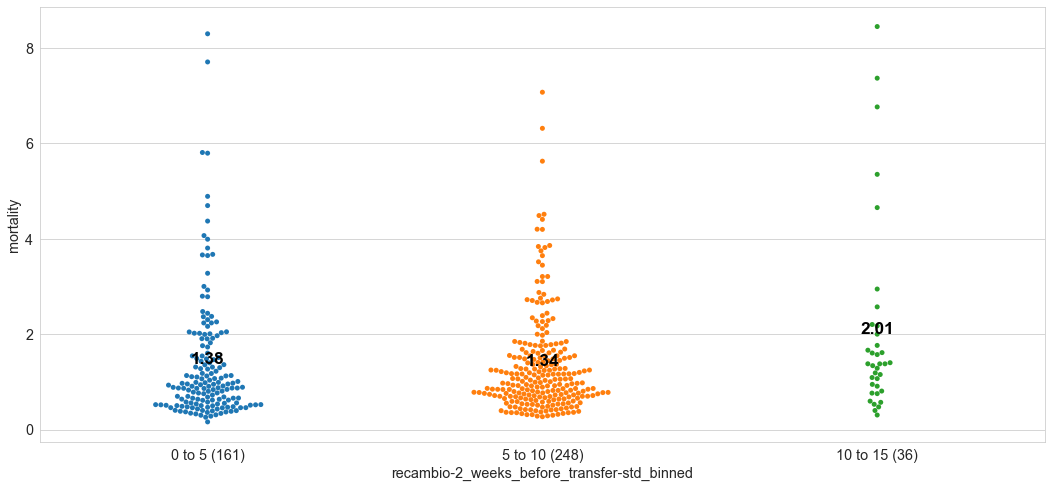

In [120]:
sns.set_style("whitegrid")

step = 5

factor = selected_mortality_pos[1]
bins_tuple=tuple(i*step for i in range(
    int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.99)/step)+1)
)
bins_tuple = (0,5,10,15)

# arr_for_chart = factors_df_with_mean_ph.copy()
arr_for_chart = factors_df.copy()

arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

x_axis_factor = factor+'_binned'
y_axis_factor = 'mortality'

plt.figure()

f, axs = plt.subplots(1,1, figsize=(18,8), sharex=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
# medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='black',weight='semibold')

# vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
# for xtick in box_plot.get_xticks():
#     box_plot.text(xtick,medians2.iloc[xtick]/2 + vertical_offset,(round(medians2.iloc[xtick],2)),
#                   horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')

# Add counts to x-axis labels
ax = plt.gca()
xtick_labels = [tick.get_text() for tick in ax.get_xticklabels()]
counts = arr_for_chart[x_axis_factor].value_counts().sort_index()

updated_labels=[]
for i,v in enumerate(xtick_labels):
    bin_range1 = v.split(", ")[0][1:]
    bin_range2 = v.split(", ")[1][:-1]
    updated_label = "{:.0f}".format(float(bin_range1))+' to ' + "{:.0f}".format(float(bin_range2))
    updated_labels.append(f"{updated_label} ({counts.iloc[i]})")
#     updated_labels.append(f"{updated_label} ")
ax.set_xticklabels(updated_labels)

# plt.savefig(f'Visualisation\\Swarmplot_{y_axis_factor}_vs_{factor}.jpg')

### Finding 2: Increased number of days with low recambio -> Decreased mortality

[Text(0, 0, '0% to 25% (143)'), Text(1, 0, '25% to 50% (31)')]

<Figure size 1080x360 with 0 Axes>

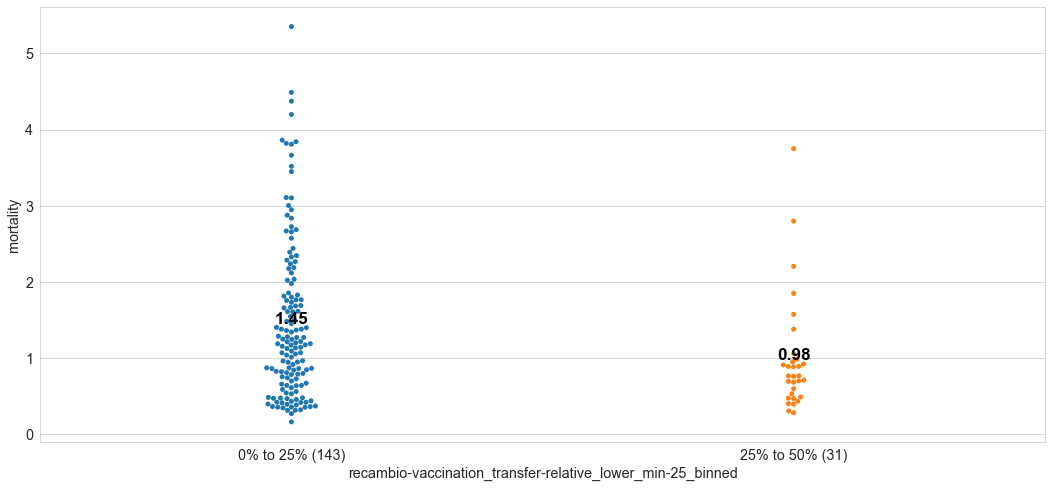

In [168]:
sns.set_style("whitegrid")

step = 0.25

factor = selected_mortality_neg[0]
bins_tuple=tuple(i*step for i in range(
    int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.99)/step)+1)
)
bins_tuple = (0,.25,.50)

# arr_for_chart = factors_df_with_mean_ph.copy()
arr_for_chart = factors_df.copy()

arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

x_axis_factor = factor+'_binned'
y_axis_factor = 'mortality'

plt.figure()

f, axs = plt.subplots(1,1, figsize=(18,8), sharex=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
# medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='black',weight='semibold')

# vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
# for xtick in box_plot.get_xticks():
#     box_plot.text(xtick,medians2.iloc[xtick]/2 + vertical_offset,(round(medians2.iloc[xtick],2)),
#                   horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')

# Add counts to x-axis labels
ax = plt.gca()
xtick_labels = [tick.get_text() for tick in ax.get_xticklabels()]
counts = arr_for_chart[x_axis_factor].value_counts().sort_index()

updated_labels=[]
for i,v in enumerate(xtick_labels):
    bin_range1 = v.split(", ")[0][1:]
    bin_range2 = v.split(", ")[1][:-1]
    updated_label = "{:.0%}".format(float(bin_range1))+' to ' + "{:.0%}".format(float(bin_range2))
    updated_labels.append(f"{updated_label} ({counts.iloc[i]})")
#     updated_labels.append(f"{updated_label} ")
ax.set_xticklabels(updated_labels)

# plt.savefig(f'Visualisation\\Swarmplot_{y_axis_factor}_vs_{factor}.jpg')

array([[  1.45088994,   0.98232454],
       [ 36.9200574 ,  33.10690732],
       [143.        ,  31.        ]])

<Figure size 1080x360 with 0 Axes>

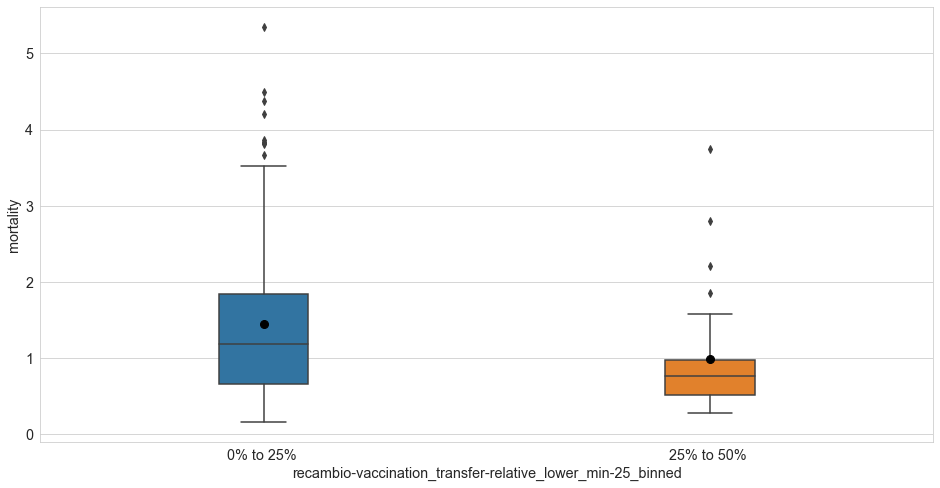

In [33]:
plot_slide_chart(factor='recambio-vaccination_transfer-relative_lower_min-25',
                 finding_name='R2',
                 low_q=.01,
                 high_q=.9,
                 step=.25,
                 format_chart='perc')

### Finding 3: increased number of extreme recambio values -> higher growth

In [153]:
selected_tgc_pos

['recambio-8_weeks_before_transfer-relative_out_min_max-25-50',
 'recambio-transfer_vaccination-std',
 'recambio-transfer_vaccination-max']

[Text(0, 0, '0% to 25% (75)'),
 Text(1, 0, '25% to 50% (83)'),
 Text(2, 0, '50% to 75% (28)')]

<Figure size 1080x360 with 0 Axes>

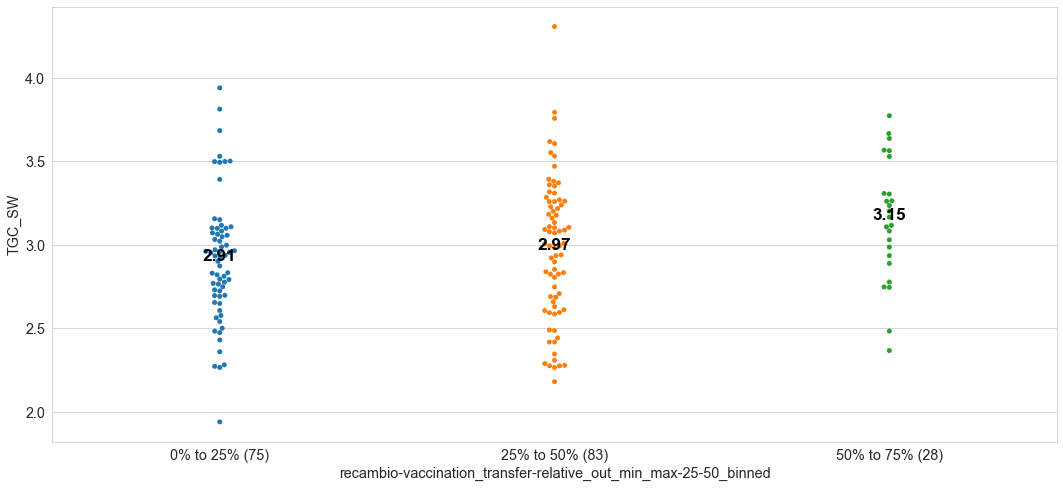

In [165]:
# sns.set_style("whitegrid")

# step = .25

# # factor = selected_tgc_pos[0]
# factor = 'recambio-vaccination_transfer-relative_out_min_max-25-50'

# bins_tuple=tuple(i*step for i in range(
#     int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.99)/step)+1)
# )
# # bins_tuple = (5,10,15)

# # arr_for_chart = factors_df_with_mean_ph.copy()
# arr_for_chart = factors_df.copy()

# arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
# arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

# x_axis_factor = factor+'_binned'
# y_axis_factor = 'TGC_SW'

# plt.figure()

# f, axs = plt.subplots(1,1, figsize=(18,8), sharex=True)
# box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
# medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
# # medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


# vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
# for xtick in box_plot.get_xticks():
#     box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
#                   horizontalalignment='center',size='xx-large',color='black',weight='semibold')

# # vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
# # for xtick in box_plot.get_xticks():
# #     box_plot.text(xtick,medians2.iloc[xtick]/2 + vertical_offset,(round(medians2.iloc[xtick],2)),
# #                   horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')

# # Add counts to x-axis labels
# ax = plt.gca()
# xtick_labels = [tick.get_text() for tick in ax.get_xticklabels()]
# counts = arr_for_chart[x_axis_factor].value_counts().sort_index()

# updated_labels=[]
# for i,v in enumerate(xtick_labels):
#     bin_range1 = v.split(", ")[0][1:]
#     bin_range2 = v.split(", ")[1][:-1]
# #     updated_label = "{:.0f}".format(float(bin_range1))+' to ' + "{:.0f}".format(float(bin_range2))
#     updated_label = "{:.0%}".format(float(bin_range1))+' to ' + "{:.0%}".format(float(bin_range2))
#     updated_labels.append(f"{updated_label} ({counts.iloc[i]})")
# #     updated_labels.append(f"{updated_label} ")
# ax.set_xticklabels(updated_labels)

# # plt.savefig(f'Visualisation\\Swarmplot_{y_axis_factor}_vs_{factor}.jpg')

In [ ]:
### Finding 3: recambio > 75% -> higher growth

<Figure size 1080x360 with 0 Axes>

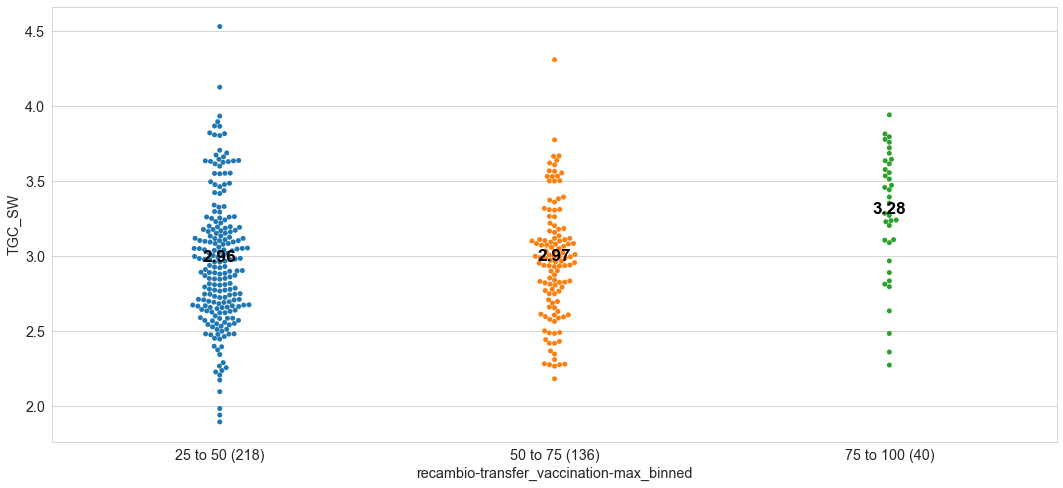

In [160]:
sns.set_style("whitegrid")

step = 25

factor = selected_tgc_pos[2]
bins_tuple=tuple(i*step for i in range(
    int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.99)/step)+1)
)
# bins_tuple = (5,10,15)

# arr_for_chart = factors_df_with_mean_ph.copy()
arr_for_chart = factors_df.copy()

arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

x_axis_factor = factor+'_binned'
y_axis_factor = 'TGC_SW'

plt.figure()

f, axs = plt.subplots(1,1, figsize=(18,8), sharex=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
# medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='black',weight='semibold')

# vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
# for xtick in box_plot.get_xticks():
#     box_plot.text(xtick,medians2.iloc[xtick]/2 + vertical_offset,(round(medians2.iloc[xtick],2)),
#                   horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')

# Add counts to x-axis labels
ax = plt.gca()
xtick_labels = [tick.get_text() for tick in ax.get_xticklabels()]
counts = arr_for_chart[x_axis_factor].value_counts().sort_index()

updated_labels=[]
for i,v in enumerate(xtick_labels):
    bin_range1 = v.split(", ")[0][1:]
    bin_range2 = v.split(", ")[1][:-1]
    updated_label = "{:.0f}".format(float(bin_range1))+' to ' + "{:.0f}".format(float(bin_range2))
#     updated_label = "{:.0%}".format(float(bin_range1))+' to ' + "{:.0%}".format(float(bin_range2))
    updated_labels.append(f"{updated_label} ({counts.iloc[i]})")
#     updated_labels.append(f"{updated_label} ")
ax.set_xticklabels(updated_labels)

# plt.savefig(f'Visualisation\\Swarmplot_{y_axis_factor}_vs_{factor}.jpg')

[Text(0, 0, '0 to 5 (11)'),
 Text(1, 0, '5 to 10 (287)'),
 Text(2, 0, '10 to 15 (91)')]

<Figure size 1080x360 with 0 Axes>

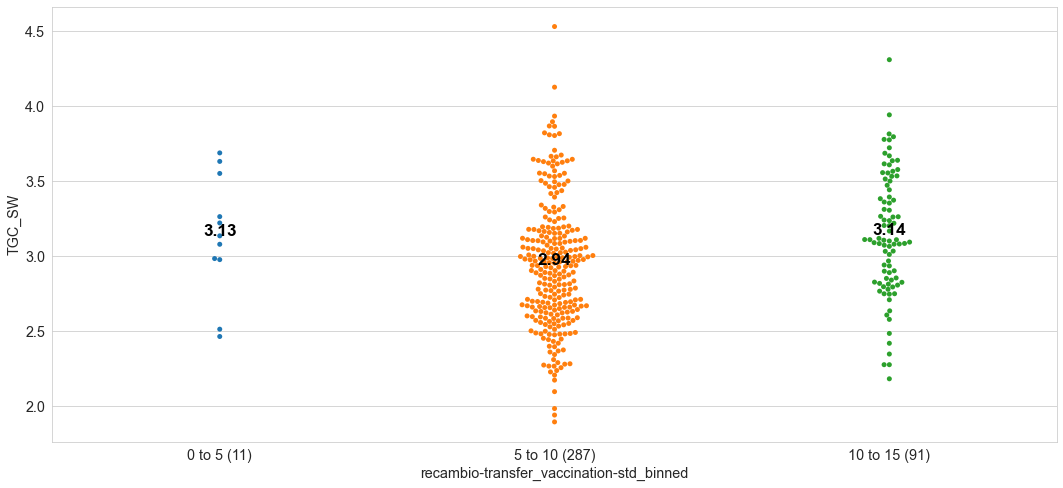

In [143]:
# sns.set_style("whitegrid")

# step = 5

# factor = selected_tgc_pos[1]
# bins_tuple=tuple(i*step for i in range(
#     int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.99)/step)+1)
# )
# # bins_tuple = (5,10,15)

# # arr_for_chart = factors_df_with_mean_ph.copy()
# arr_for_chart = factors_df.copy()

# arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
# arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

# x_axis_factor = factor+'_binned'
# y_axis_factor = 'TGC_SW'

# plt.figure()

# f, axs = plt.subplots(1,1, figsize=(18,8), sharex=True)
# box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
# medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
# # medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


# vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
# for xtick in box_plot.get_xticks():
#     box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
#                   horizontalalignment='center',size='xx-large',color='black',weight='semibold')

# # vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
# # for xtick in box_plot.get_xticks():
# #     box_plot.text(xtick,medians2.iloc[xtick]/2 + vertical_offset,(round(medians2.iloc[xtick],2)),
# #                   horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')

# # Add counts to x-axis labels
# ax = plt.gca()
# xtick_labels = [tick.get_text() for tick in ax.get_xticklabels()]
# counts = arr_for_chart[x_axis_factor].value_counts().sort_index()

# updated_labels=[]
# for i,v in enumerate(xtick_labels):
#     bin_range1 = v.split(", ")[0][1:]
#     bin_range2 = v.split(", ")[1][:-1]
#     updated_label = "{:.0f}".format(float(bin_range1))+' to ' + "{:.0f}".format(float(bin_range2))
# #     updated_label = "{:.0%}".format(float(bin_range1))+' to ' + "{:.0%}".format(float(bin_range2))
#     updated_labels.append(f"{updated_label} ({counts.iloc[i]})")
# #     updated_labels.append(f"{updated_label} ")
# ax.set_xticklabels(updated_labels)

# # plt.savefig(f'Visualisation\\Swarmplot_{y_axis_factor}_vs_{factor}.jpg')

In [166]:
factors_df.notna().sum()

locus_id                                                    1262
fish_group_id                                               1262
transfer_year                                               1262
recambio-2_weeks_before_transfer-cv                          453
recambio-2_weeks_before_transfer-cv-from_mean                453
                                                            ... 
recambio-vaccination_transfer-relative_higher_max-50         205
recambio-vaccination_transfer-relative_lower_min-25          205
recambio-vaccination_transfer-relative_out_min_max-25-50     205
mortality                                                   1262
TGC_SW                                                      1196
Length: 125, dtype: int64

### Finding 3:  Relative higher max vs mortality

In [34]:
highest_corr.iloc[0].name

'ph-first_feeding_transfer-relative_higher_max-7.3'

[Text(0, 0, '0% to 10% (126)'), Text(1, 0, '10% to 20% (50)')]

<Figure size 1080x360 with 0 Axes>

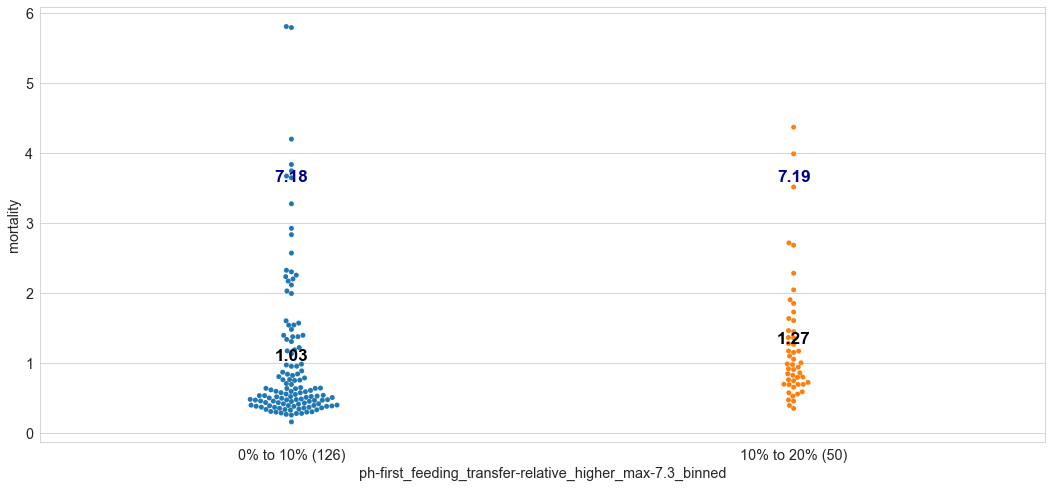

In [156]:
sns.set_style("whitegrid")

step = 0.1

# factor = 'relative_higher_max_first_feeding_transfer'
factor = 'ph-first_feeding_transfer-relative_higher_max-7.3'
# factor = 'ph-first_feeding_vaccination-relative_higher_max-7.3'
# factor = 'ph-first_feeding_vaccination-relative_higher_max-7.3'
# factor = 'ph-vaccination_transfer-relative_higher_max-7.3'
# factor = 'ph-8_weeks_before_transfer-relative_higher_max-7.3'


bins_tuple=tuple(i*step for i in range(
    int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.99)/step)+1)
)
arr_for_chart = factors_df_with_mean_ph.copy()
arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

x_axis_factor = factor+'_binned'
y_axis_factor = 'mortality'

plt.figure()

f, axs = plt.subplots(1,1, figsize=(18,8), sharex=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
# box_plot=sns.boxplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)

medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


vertical_offset = arr_for_chart[y_axis_factor].median() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='black',weight='semibold')

vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians2.iloc[xtick]/2 + vertical_offset,(round(medians2.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')
    
# Add counts to x-axis labels
ax = plt.gca()
xtick_labels = [tick.get_text() for tick in ax.get_xticklabels()]
counts = arr_for_chart[x_axis_factor].value_counts().sort_index()

updated_labels=[]
for i,v in enumerate(xtick_labels):
    bin_range1 = v.split(", ")[0][1:]
    bin_range2 = v.split(", ")[1][:-1]
    updated_label = "{:.0%}".format(float(bin_range1))+' to ' + "{:.0%}".format(float(bin_range2))
    updated_labels.append(f"{updated_label} ({counts.iloc[i]})")
#     updated_labels.append(f"{updated_label} ")
ax.set_xticklabels(updated_labels)

# plt.show()
# plt.savefig(f'Visualisation\Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average.jpg')
# plt.savefig(f'Visualisation\Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average2.jpg')
# plt.savefig(f'Visualisation\Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average3.jpg')
# plt.savefig(f'Visualisation\Boxplot_{y_axis_factor}_vs_{factor}.jpg')

### FInding 4: Mortality vs relative_lower_min

<Figure size 1080x360 with 0 Axes>

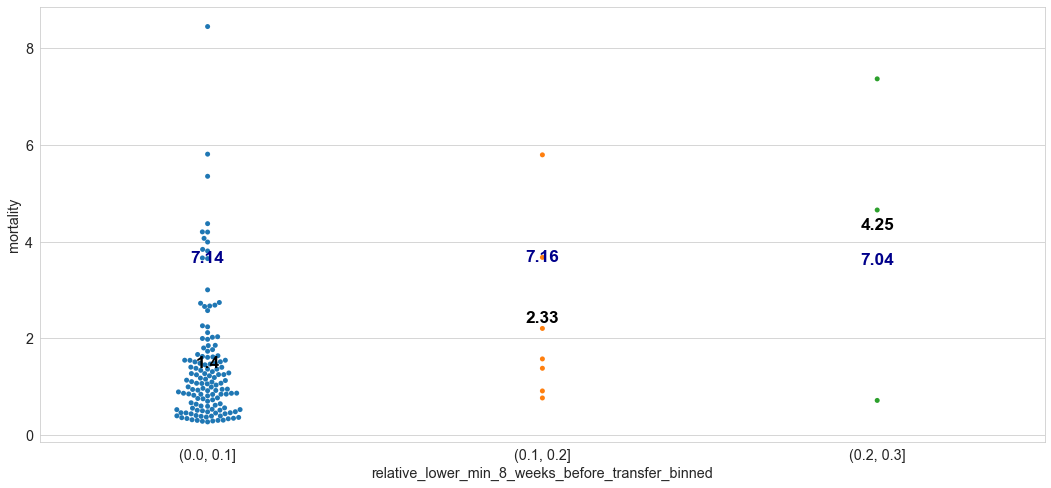

<Figure size 1080x360 with 0 Axes>

In [91]:
sns.set_style("whitegrid")

step = 0.1

factor = 'relative_lower_min_8_weeks_before_transfer'
bins_tuple=tuple(i*step for i in range(
    int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.986)/step)+1)
)
arr_for_chart = factors_df_with_mean_ph.copy()
arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

x_axis_factor = factor+'_binned'
y_axis_factor = 'mortality'

plt.figure()

f, axs = plt.subplots(1,1, figsize=(18,8), sharex=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='black',weight='semibold')

vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians2.iloc[xtick]/2 + vertical_offset,(round(medians2.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')
plt.show()
plt.savefig(f'Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average.jpg')

### Finding 5: TGC vs 8_weeks_before_transfer_max 

<Figure size 1080x360 with 0 Axes>

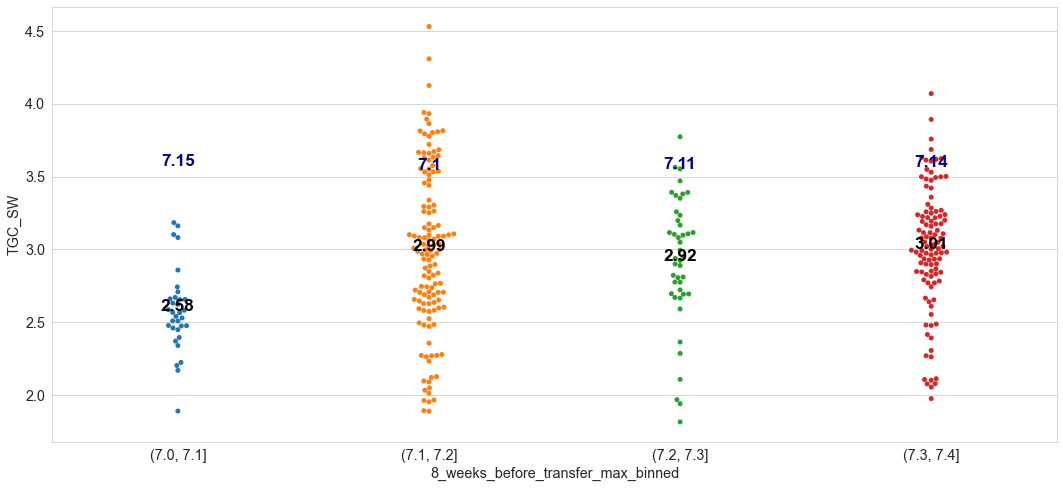

<Figure size 1080x360 with 0 Axes>

In [93]:
sns.set_style("whitegrid")

step = 0.1

factor = '8_weeks_before_transfer_max'
bins_tuple=tuple(i*step for i in range(
    int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.8)/step)+1)
)
arr_for_chart = factors_df_with_mean_ph.copy()
arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

x_axis_factor = factor+'_binned'
y_axis_factor = 'TGC_SW'

plt.figure()

f, axs = plt.subplots(1,1, figsize=(18,8), sharex=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='black',weight='semibold')

vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians2.iloc[xtick]/2 + vertical_offset,(round(medians2.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')
plt.show()
plt.savefig(f'Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average.jpg')

### Finding 6: TGC vs ph_transfer_vaccination_std

<Figure size 1080x360 with 0 Axes>

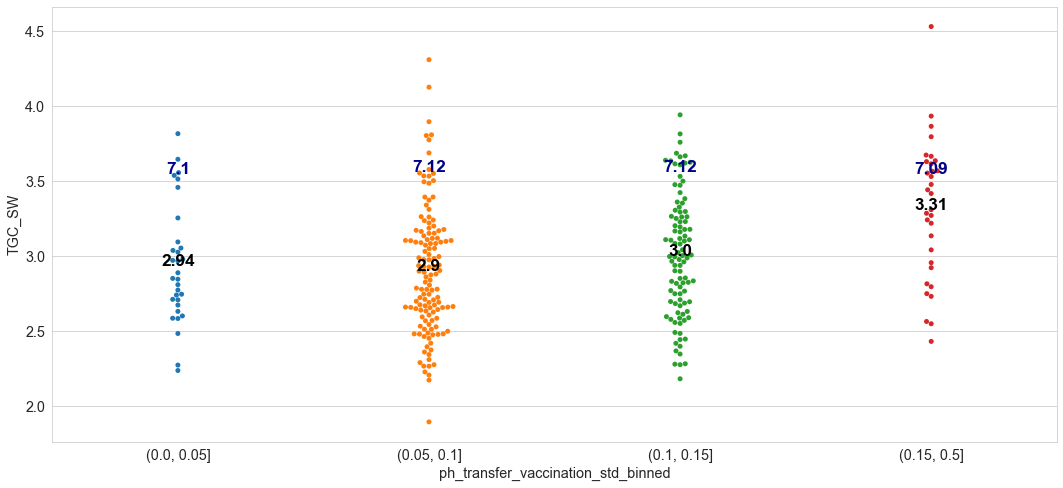

<Figure size 1080x360 with 0 Axes>

In [99]:
sns.set_style("whitegrid")

step = 0.15

factor = 'ph_transfer_vaccination_std'
# bins_tuple=tuple(i*step for i in range(
#     int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.8)/step)+1)
# )
bins_tuple = (0.0, 0.05, 0.1, 0.15, 0.5)
arr_for_chart = factors_df_with_mean_ph.copy()
arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

x_axis_factor = factor+'_binned'
y_axis_factor = 'TGC_SW'

plt.figure()

f, axs = plt.subplots(1,1, figsize=(18,8), sharex=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='black',weight='semibold')

vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians2.iloc[xtick]/2 + vertical_offset,(round(medians2.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')
plt.show()
plt.savefig(f'Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average.jpg')

In [52]:
factors_df.columns

Index(['locus_id', 'fish_group_id', 'transfer_year',
       'ph-2_weeks_before_transfer-cv',
       'ph-2_weeks_before_transfer-cv-from_mean',
       'ph-2_weeks_before_transfer-cv-from_mean-abs',
       'ph-2_weeks_before_transfer-max',
       'ph-2_weeks_before_transfer-max-from_mean',
       'ph-2_weeks_before_transfer-max-from_mean-abs',
       'ph-2_weeks_before_transfer-mean',
       ...
       'ph-transfer_vaccination-std-from_mean',
       'ph-transfer_vaccination-std-from_mean-abs',
       'ph-vaccination_transfer-btw_min_max-6.9-7.3',
       'ph-vaccination_transfer-higher_max-7.3',
       'ph-vaccination_transfer-lower_min-6.9',
       'ph-vaccination_transfer-relative_higher_max-7.3',
       'ph-vaccination_transfer-relative_lower_min-6.9',
       'ph-vaccination_transfer-relative_out_min_max-6.9-7.3', 'mortality',
       'TGC_SW'],
      dtype='object', length=119)

In [53]:
significant_factors = [
    'ph-8_weeks_before_transfer-std',
    'ph-8_weeks_before_transfer-max',
    'ph-8_weeks_before_transfer-relative_higher_max-7.3',
    'ph-8_weeks_before_transfer-relative_lower_min-6.9',
    'ph-transfer_vaccination-std'
]

In [54]:
key_factors = ['locus_id', 'fish_group_id', 'transfer_year']
targets = ['mortality', 'TGC_SW']

In [55]:
sig_factors_df = factors_df[key_factors + significant_factors + targets]

In [58]:
sig_factors_df.to_csv('./data/significant_factors_ph.csv', index=False)

## Various swarmplots (TGC)

<Figure size 1080x360 with 0 Axes>

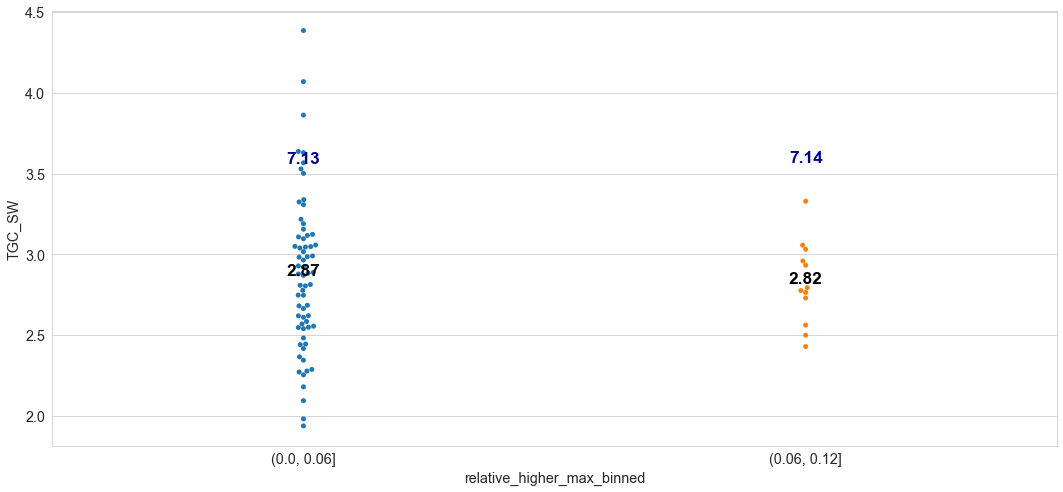

<Figure size 1080x360 with 0 Axes>

In [59]:
sns.set_style("whitegrid")

step=0.06

factor = 'relative_higher_max'
bins_tuple=tuple(i*step for i in range(
    int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.99)/step)+1)
)
arr_for_chart = factors_df_with_mean_ph.copy()
arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

x_axis_factor = factor+'_binned'
y_axis_factor = 'TGC_SW'

plt.figure()

f, axs = plt.subplots(1,1, figsize=(18,8), sharex=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='black',weight='semibold')

vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians2.iloc[xtick]/2 + vertical_offset,(round(medians2.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')
plt.show()
plt.savefig(f'Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average.jpg')

<Figure size 1080x360 with 0 Axes>

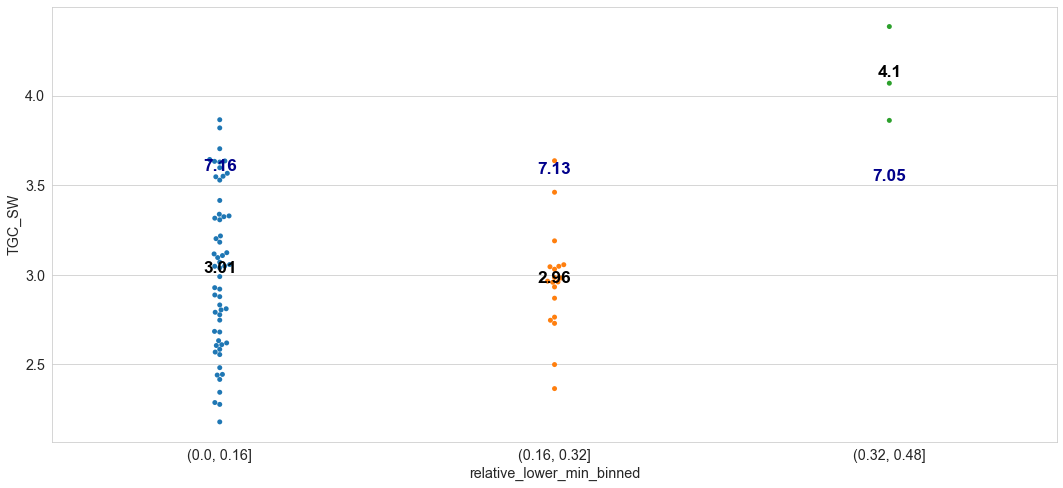

<Figure size 1080x360 with 0 Axes>

In [60]:
sns.set_style("whitegrid")

step=0.16

factor = 'relative_lower_min'
bins_tuple=tuple(i*step for i in range(
    int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.99)/step)+1)
)
arr_for_chart = factors_df_with_mean_ph.copy()
arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

x_axis_factor = factor+'_binned'
y_axis_factor = 'TGC_SW'

plt.figure()

f, axs = plt.subplots(1,1, figsize=(18,8), sharex=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='black',weight='semibold')

vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians2.iloc[xtick]/2 + vertical_offset,(round(medians2.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')
plt.show()
plt.savefig(f'Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average.jpg')

<Figure size 1080x360 with 0 Axes>

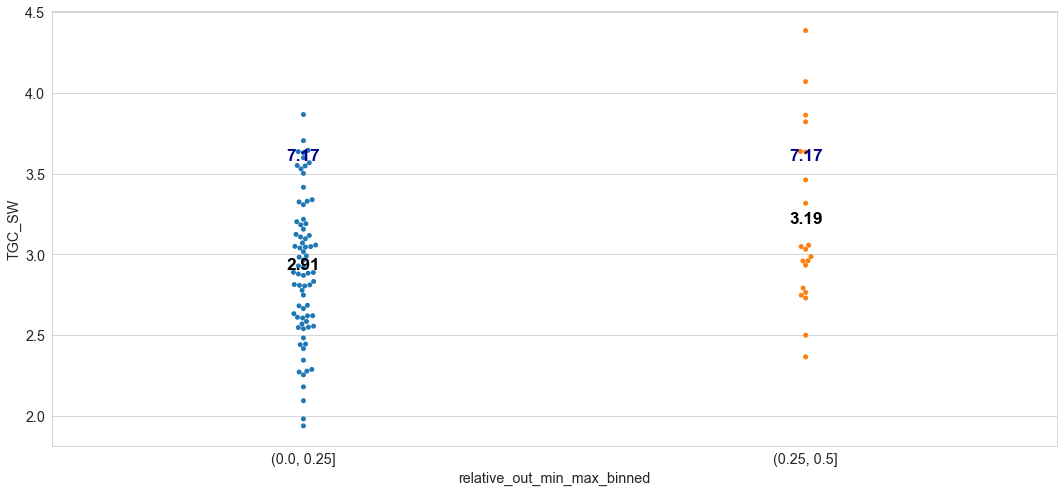

<Figure size 1080x360 with 0 Axes>

In [58]:
sns.set_style("whitegrid")

step=0.25


factor = 'relative_out_min_max'
bins_tuple=tuple(i*step for i in range(
    int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.99)/step)+1)
)
arr_for_chart = factors_df_with_mean_ph.copy()
arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

x_axis_factor = factor+'_binned'
y_axis_factor = 'TGC_SW'

plt.figure()

f, axs = plt.subplots(1,1, figsize=(18,8), sharex=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='black',weight='semibold')

vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians2.iloc[xtick]/2 + vertical_offset,(round(medians2.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')
plt.show()
plt.savefig(f'Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average.jpg')

<Figure size 1080x360 with 0 Axes>

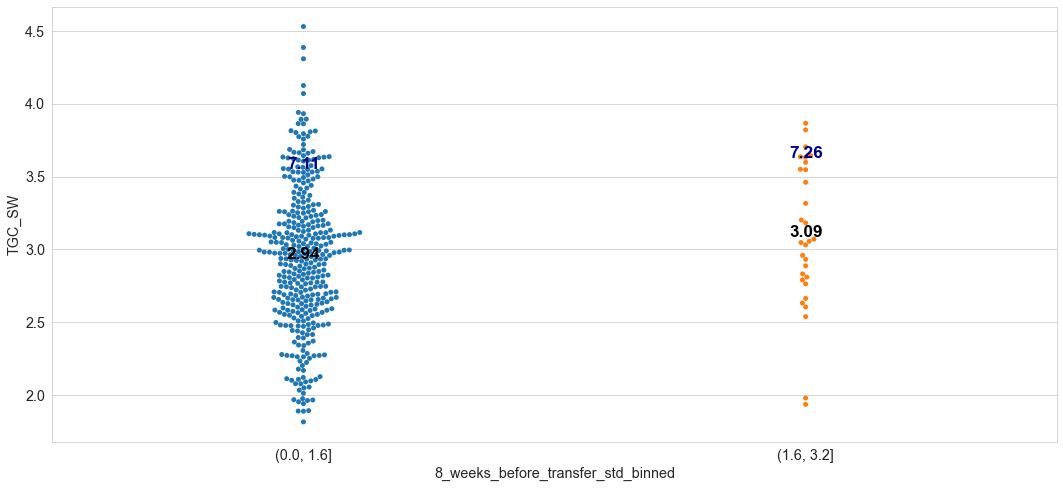

<Figure size 1080x360 with 0 Axes>

In [68]:
sns.set_style("whitegrid")

step=1.6

factor = '8_weeks_before_transfer_std'
bins_tuple=tuple(i*step for i in range(
    int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.99)/step)+1)
)
arr_for_chart = factors_df_with_mean_ph.copy()
arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

x_axis_factor = factor+'_binned'
y_axis_factor = 'TGC_SW'

plt.figure()

f, axs = plt.subplots(1,1, figsize=(18,8), sharex=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='black',weight='semibold')

vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians2.iloc[xtick]/2 + vertical_offset,(round(medians2.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')
plt.show()
plt.savefig(f'Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average.jpg')

<Figure size 1080x360 with 0 Axes>

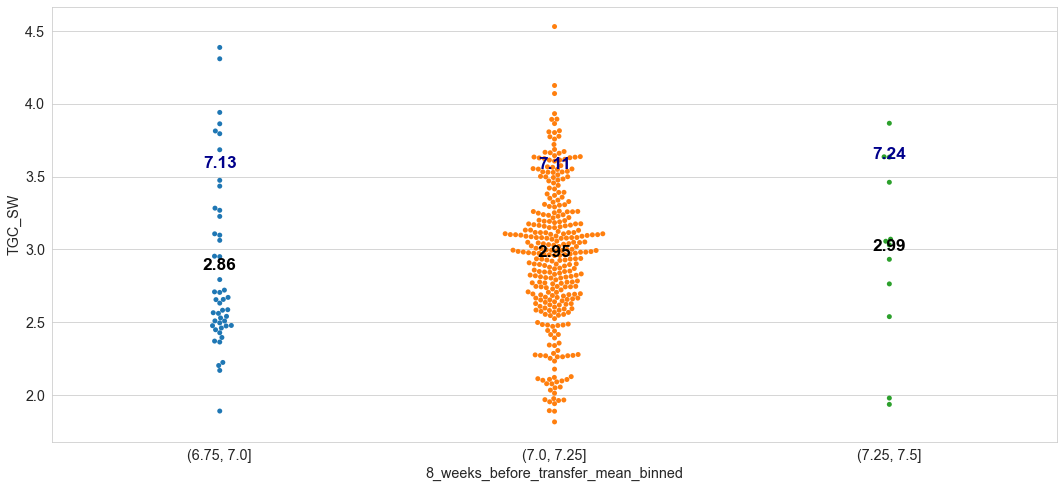

<Figure size 1080x360 with 0 Axes>

In [69]:
sns.set_style("whitegrid")

step=0.25

factor = '8_weeks_before_transfer_mean'
bins_tuple=tuple(i*step for i in range(
    int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.99)/step)+1)
)
arr_for_chart = factors_df_with_mean_ph.copy()
arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

x_axis_factor = factor+'_binned'
y_axis_factor = 'TGC_SW'

plt.figure()

f, axs = plt.subplots(1,1, figsize=(18,8), sharex=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='black',weight='semibold')

vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians2.iloc[xtick]/2 + vertical_offset,(round(medians2.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')
plt.show()
plt.savefig(f'Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average.jpg')

<Figure size 1080x360 with 0 Axes>

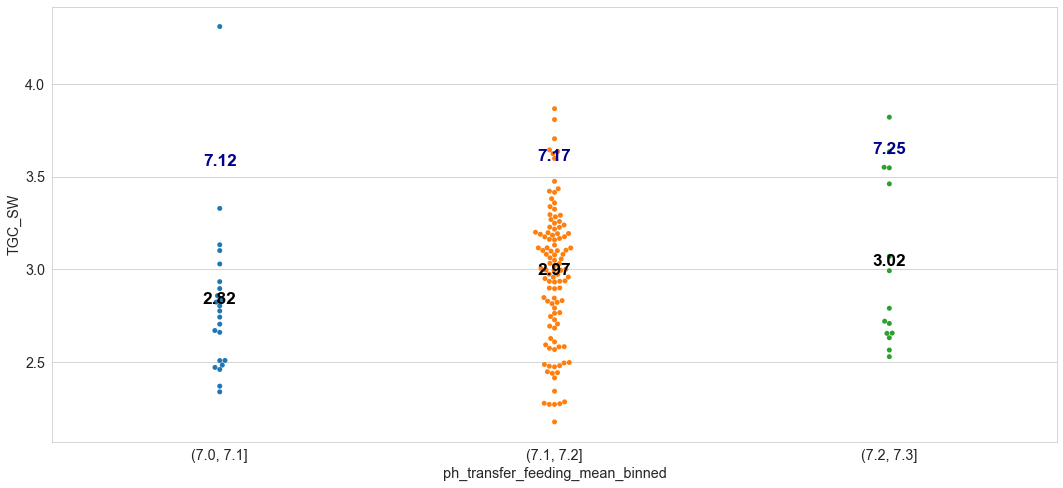

<Figure size 1080x360 with 0 Axes>

In [70]:
sns.set_style("whitegrid")

step=0.1

factor = 'ph_transfer_feeding_mean'
bins_tuple=tuple(i*step for i in range(
    int(factors_df[factor].quantile(.01)/step), int(factors_df[factor].quantile(.99)/step)+1)
)
arr_for_chart = factors_df_with_mean_ph.copy()
arr_for_chart[factor+'_binned'] = pd.cut(factors_df[factor], bins=bins_tuple)
arr_for_chart['mortality'] = arr_for_chart['mortality'] * 100

x_axis_factor = factor+'_binned'
y_axis_factor = 'TGC_SW'

plt.figure()

f, axs = plt.subplots(1,1, figsize=(18,8), sharex=True)
box_plot=sns.swarmplot(data=arr_for_chart,x=x_axis_factor,y=y_axis_factor)
medians = arr_for_chart.groupby(x_axis_factor)[y_axis_factor].mean()
medians2 = arr_for_chart.groupby(x_axis_factor)[main_factor].mean()


vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians.iloc[xtick] + vertical_offset,(round(medians.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='black',weight='semibold')

vertical_offset = arr_for_chart[y_axis_factor].mean() * 0.00 # offset from median for display
for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians2.iloc[xtick]/2 + vertical_offset,(round(medians2.iloc[xtick],2)),
                  horizontalalignment='center',size='xx-large',color='darkblue',weight='semibold')
plt.show()
plt.savefig(f'Swarmplot_{y_axis_factor}_vs_{factor}_with_ph_average.jpg')